In [93]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import os, json

import torch as ch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [94]:
import utils
import implem_utils

In [95]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

def get_input_tensors(img):
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)

In [96]:
MODELPATH = "/u/as9rw/work/fnb/implems/celeba_models_split/70_30/split_1/all/augment_vggface/10_0.928498243559719.pth"

model = utils.FaceModel(512,
                        train_feat=True,
                        weight_init=None,
                        hidden=[64, 16]).cuda()
model = nn.DataParallel(model)
model.load_state_dict(ch.load(MODELPATH), strict=False)
model.eval()

DataParallel(
  (module): FaceModel(
    (feature_model): InceptionResnetV1(
      (conv2d_1a): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (conv2d_2a): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (conv2d_2b): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2d_3b): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False

In [97]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [129]:
constants = utils.Celeb()
ds = constants.get_dataset()

td = utils.CelebACustomBinary(
        "/p/adversarialml/as9rw/datasets/celeba_raw_crop/splits/70_30/all/split_2/test",
        transform=transform)

cropped_dataloader = DataLoader(td,
                                batch_size=100,
                                shuffle=True)

In [130]:
x, y = next(iter(cropped_dataloader))

In [131]:
def raw_255_image(z):
    z_ = z.numpy().transpose(1, 2, 0)
    z_ = (z_ + 1) / 2
    return (z_ * 255).astype(np.uint8)

In [132]:
def show_image(z):
    plt.imshow(raw_255_image(z))

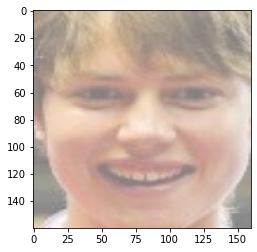

In [148]:
want_index = 34
img_t = x[want_index:want_index+1]
logits = model(img_t.cuda()).detach()

show_image(x[want_index])

In [149]:
probs = F.sigmoid(logits)
probs = ch.stack([1 - probs[:, 0], probs[:, 0]], 1)

/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [150]:
def batch_predict(images):
    batch = torch.stack(tuple(transform(i) for i in images), dim=0)
    
    logits = model(batch.cuda()).detach()
    probs = F.sigmoid(logits)
    probs = ch.stack([1 - probs[:, 0], probs[:, 0]], 1)
    return probs.cpu().numpy()

In [151]:
test_pred = batch_predict([raw_255_image(img_t[0])])
test_pred.squeeze().argmax()

1

In [152]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(raw_255_image(img_t[0]),
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)

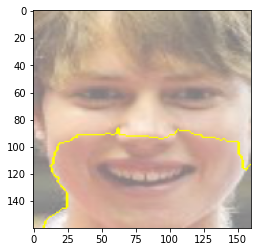

In [153]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

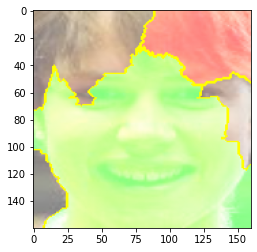

In [154]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)